In [1]:
### Librerias

import pandas as pd ### para manejo de datos
import a_funciones as funciones  ###archivo de funciones propias
import numpy as np #procesamiento eficiente de grandes conjuntos de datos y la realización de operaciones matemáticas
import plotly.express as px # Graficas lindas
from sklearn.model_selection import RandomizedSearchCV # búsqueda aleatoria de hiperparámetros 
import joblib  ### para guardar y cargar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables 
import openpyxl # trabajar con archivos de Excel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.ensemble import RandomForestClassifier  # Clasificador bosques aleatoriost 
from sklearn.tree import DecisionTreeClassifier # Arboles de decision 
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler ## escalar variable
from sklearn.ensemble import GradientBoostingClassifier #Modelo de clasificacion
from sklearn.metrics import confusion_matrix #### Matriz de confusion 
import matplotlib.pyplot as plt #####Graficos
import seaborn as sns #####Graficos
from sklearn.metrics import accuracy_score #### medir precision del modelo 

In [2]:
### Cargar base desde github

df_ = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/df_fin.csv", sep=",")

## **Tratamiento de nulos, y imputacíon**

In [3]:
### Visualizacion de datos
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EnvironmentSatisfaction  4309 non-null   int64 
 1   JobSatisfaction          4309 non-null   int64 
 2   WorkLifeBalance          4309 non-null   int64 
 3   Age                      4309 non-null   int64 
 4   BusinessTravel           4309 non-null   object
 5   Department               4309 non-null   object
 6   DistanceFromHome         4309 non-null   int64 
 7   Education                4309 non-null   int64 
 8   EducationField           4309 non-null   object
 9   Gender                   4309 non-null   object
 10  JobLevel                 4309 non-null   int64 
 11  JobRole                  4309 non-null   object
 12  MaritalStatus            4309 non-null   object
 13  MonthlyIncome            4309 non-null   int64 
 14  NumCompaniesWorked       4309 non-null  

In [4]:
"""Como no tiene nulos, no se hace ningun tratamiento"""

### Crear lista de variables categoricas 

columnas = df_.columns
#list_cat = [col for col in columnas if df4[col].dtype == 'object']
#print(list_cat)

list_cat =['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [5]:
### Imputación para variables categoricas y numericas

df3 = funciones.imputar_f(df_,list_cat)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   BusinessTravel  4309 non-null   object
 1   Department      4309 non-null   object
 2   EducationField  4309 non-null   object
 3   Gender          4309 non-null   object
 4   JobRole         4309 non-null   object
 5   MaritalStatus   4309 non-null   object
dtypes: object(6)
memory usage: 202.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4309 non-null   float64
 1   JobSatisfaction          4309 non-null   float64
 2   WorkLifeBalance          4309 non-null   float64
 3   Age                      4309 non-null   float64
 4   DistanceFromHome         4309 non-null   float64
 5   Education 

## **Obtener dummies**

In [6]:
#### Creamos lista de dummies
list_dummies = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [7]:
### Conversion a categoricas a dummie
df = pd.get_dummies(df3, columns=list_dummies)

In [8]:
### Separamos nuestra variable objetivo de las demas
y=df.Attrition
X1= df.loc[:,~df.columns.isin(['Attrition'])]


In [9]:
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

## **Seleccion de variables**

In [10]:
######Seleccion de modelos

### 1. Regresion logistica --> se selecciono debido a su facil implementacion, no requiere ajuste de 
###                            hiperparametros; carga mas rapido, es bueno en problemas de clasificacion binaria.
m_rl = LogisticRegression()

### 2. Random forest       --> se selecciono porque su rendimiento generalmente es muy bueno, dando siempre 
###                            resultados satisfactorios, tambien porque es bueno en modelos que tienen muchas 
###                            variables categoricas como esté.
m_rf = RandomForestClassifier()

### 3 Arboles de decision  --> Se selecciono porque su estructura es facil de implementar, y su ajuste de  
###                             hiperparametros no es muy pesado.
m_add = DecisionTreeClassifier()

### 4 GradientBoostingClassifier --> Se selecciono porque es un modelo muy usado en problemas de clasificacion, y nunca lo he
###                                  probado 
m_gbc = GradientBoostingClassifier()


In [11]:
### Lista de modelos
modelos = list([m_rl, m_rf, m_add, m_gbc])

In [12]:
#####Seleccion de variables 
var_names=funciones.sel_variables(modelos,X,y,threshold="2.8*mean") ### 2.8 porque no es muy alto, 
###                                                       l         lo que permite una seleccion mas flexible
var_names.shape


(4,)

In [13]:
X2=X[var_names] ### matriz con variables seleccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              4309 non-null   float64
 1   JobSatisfaction  4309 non-null   float64
 2   MonthlyIncome    4309 non-null   float64
 3   YearsAtCompany   4309 non-null   float64
dtypes: float64(4)
memory usage: 134.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EnvironmentSatisfaction            4309 non-null   float64
 1   JobSatisfaction                    4309 non-null   float64
 2   WorkLifeBalance                    4309 non-null   float64
 3   Age                                4309 non-null   float64
 4   DistanceFromHome                   4309 non-null   float64
 5   Education       

## **Modelo ganador**

In [14]:
## base con todas las variables
rmse_df = funciones.medir_modelos(modelos, "f1",X,y,10)
## base con variables seleccionadas
rmse_varsel = funciones.medir_modelos(modelos,"f1",X2,y,10)



In [15]:
rmse=pd.concat([rmse_df,rmse_varsel],axis=1)
rmse.columns=['rl', 'rf', 'add', 'm_gbc',
       'rl_Sel', 'rf_sel', 'add_sel', 'm_gbc_sel']

<Axes: >

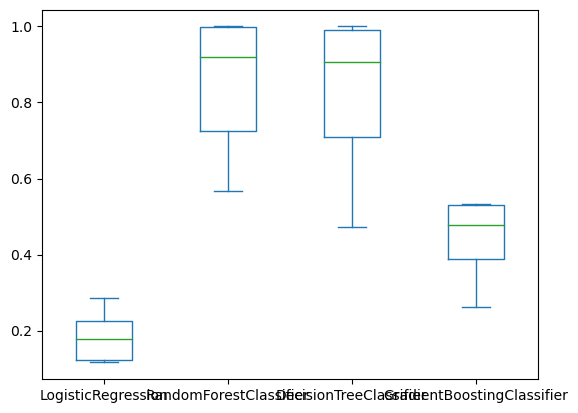

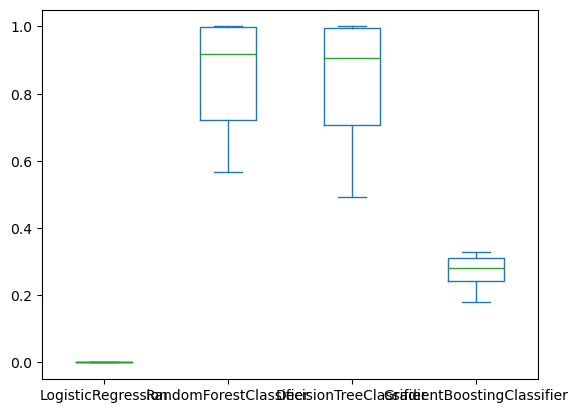

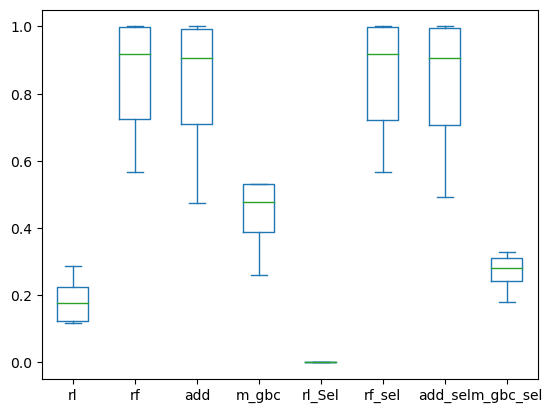

In [16]:
rmse_df.plot(kind='box') #### gráfico para modelos todas las varibles
rmse_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas
rmse.plot(kind='box') ### gráfico para modelos sel y todas las variables

rl           0.182399
rf           0.850835
add          0.825662
m_gbc        0.438387
rl_Sel       0.000000
rf_sel       0.856919
add_sel      0.828133
m_gbc_sel    0.270423
dtype: float64

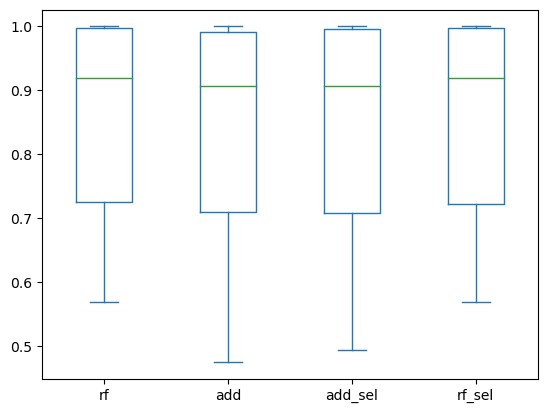

In [17]:
rmse2=rmse[['rf', 'add', 'add_sel', 'rf_sel']]
rmse2.plot(kind='box') ### gráfico para modelos sel y todas las variables
rmse.mean() ### medias de mape

Se selecciono el random forest porque en el mape de medias fue el mas alto, tambien porque en el grafico de
cajas está muy cerca a "1" 

## **Afinamiento de hiperparámetros**

**Random forest con selección de variables, antes de ajustes de hiperparámetros**

In [18]:
# Dividir los datos en conjuntos de entrenamiento y prueba; 80% y 20% 
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42, stratify = y)

# Entrenar el modelo de Random Forest
m_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = m_rf.predict(X_test)

In [19]:
# Crear y ajustar el modelo Random Forest
rf_sfs = RandomForestClassifier()
rf_sfs.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred1 = rf_sfs.predict(X_test)

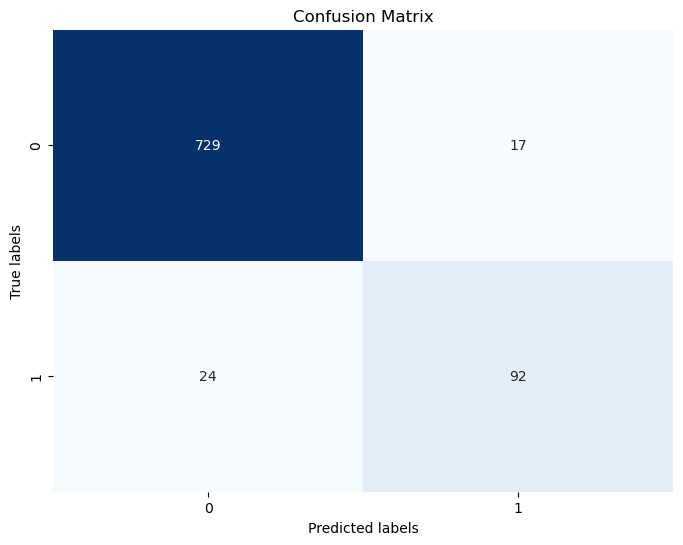

<Figure size 640x480 with 0 Axes>

In [20]:
###Matriz de confusión 

conf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Descargar imagen 
#plt.savefig('Matrizs\\confusion_matrix_antes_del_ajuste_de_hip.png')

In [21]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred1)
print(f'Precisión del modelo: {accuracy}')


Precisión del modelo: 0.9524361948955916


Conclusiones: 

Matriz de confusión; 
1. El modelo ha identificado correctamente a 92 empleados que renunciaron.
2. Hay 17 empleados que siguen en la empresa pero que fueron identificados incorrectamente como renunciantes. 
3. Hay 24 empleados que renunciaron pero que fueron identificados incorrectamente como que siguen en la empresa
4. El modelo ha identificado correctamente a 729 empleados que siguen en la empresa 

Metrica de evaluación accuracy; 
La precisión del modelo es del 95.2%, lo que indica que clasifica correctamente casi el 95% de los casos en el conjunto de prueba. Esto sugiere que el modelo es efectivo para predecir la deserción de empleados en la empresa.



**Random forest con selección de variables, con ajustes de hiperparámetros**

In [22]:
# Hiperparameter tunning
param_grid = [{'n_estimators': [3, 500, 100], 'max_features': [5,20],
               'min_samples_split': [100, 20, 5]}]


In [23]:
# Ajuste del modelo 
tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=10,scoring="f1")
tun_rf.fit(X_train,y_train)

# Hacer predicciones en el conjunto de prueba
y_pred3 = tun_rf.predict(X_test)

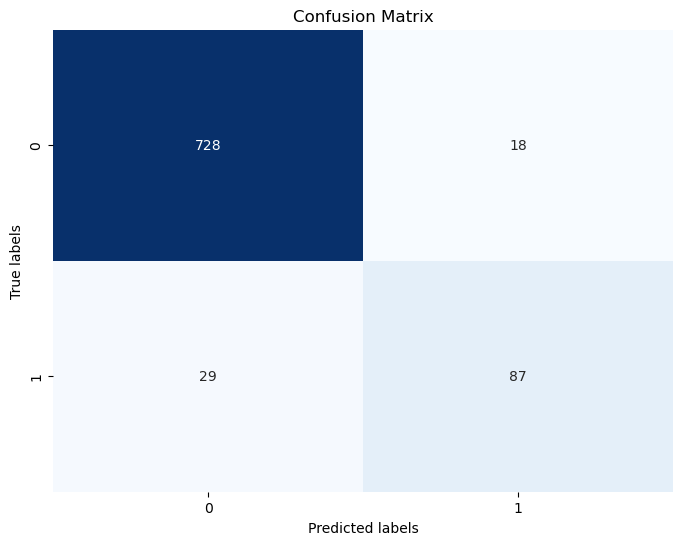

<Figure size 640x480 with 0 Axes>

In [24]:
# Matriz de confusión 
conf_matrix = confusion_matrix(y_test, y_pred3)

# Crear un mapa de calor con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Descargar imagen 
#plt.savefig('Matrizs\\confusion_matrix_con_ajuste_de_hip.png')

In [25]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred3)
print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.9454756380510441


Conclusiones; en este caso se concluira la comparación de los dos modelos, con y sin hiperparametros. No se 
dan conclusiones individuales para el modelo con hiperparametros, porque serian casi las mismas que sin 
hiperparametros. 

1. Ambas matrices muestran un buen rendimiento del modelo, con una cantidad relativamente baja de falsos positivos y falsos negativos. 
2. La precisión del modelo es alta en ambos casos, con un 95.2% sin afinamiento de hiperparámetros y un 94.5% con afinamiento de hiperparámetros. 
3. el afinamiento de hiperparámetros no ha tenido un impacto significativo en la precisión del modelo.

## **Exportación del modelo**

In [26]:
### Guardar el modelo

rf_final = tun_rf.best_estimator_ 

In [27]:
### Exportar funciones y modelo

joblib.dump(rf_final, "salidas\\rf_final.pkl") ## modelo con afinamiento
joblib.dump(list_cat, "salidas\\list_cat.pkl") ### para realizar imputacion
joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "salidas\\var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "salidas\\scaler.pkl") ## 

['salidas\\scaler.pkl']

## **Importancia de las variables**

In [28]:
importancia = pd.DataFrame({'variable': X_train.columns, 'peso': rf_final.feature_importances_})

# Ordenar por importancia
importancia = importancia.sort_values('peso', ascending=False)

# Mostrar las primeras filas (las más importantes)
print(importancia.head())

          variable      peso
2    MonthlyIncome  0.504355
0              Age  0.244419
3   YearsAtCompany  0.167078
1  JobSatisfaction  0.084148


In [29]:
importancia.sort_values(by=["peso"], ascending=False)
importancia.to_excel("salidas\\feature_importances.xlsx")
rf_final.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

Conclusiones: 

1. El ingreso mensual de los empleados es un factor crucial en la predicción de la rotación del personal. Podría indicar que  no se esta pagando lo suficiente, tambien que los empleados con ingresos más altos tienen menos probabilidades de abandonar la empresa.
2. La edad de los empleados influye en su decisión de quedarse o irse, posiblemente indicando que los empleados más jóvenes o más mayores tienen diferentes tasas de rotación.
3. la cantidad de años que un empleado ha estado en la empresa también es un factor relevante en la rotación del personal. Los empleados con más tiempo en la empresa pueden tener menos probabilidades de irse.